## ML Kick starter - Churn

- This is a kick starter ML notebook for BearingPoint 

###Download dataset

In [ ]:
# Import necessary functions 
import os
import requests 
import pandas as pd

In [ ]:
churn_path = 'https://raw.githubusercontent.com/casvalesen/mlflow_telco_churn/master/data/telco_churn.csv'

## Have a quick look at the churn data

In [ ]:
churn_data = pd.read_csv(churn_path)
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Clean data 

We apply standard formatting we will need to the entire dataset. In a production setting, we would have to replicate this logic for the inference setup. Properly simulating this should define a pipeline that can be reused on the holdout set. However, for our simple example we will apply standard format cleaning on all data

**Data cleaning trap 1**: 
- Remember to only fill zeros based on statistics learned from the training data. If the holdout set is used then we will get data leakage

## Split into train, validation and test set to avoid implicit data leakage

**Separate out a test set that the model will never see in training**

In [ ]:
from sklearn.model_selection import train_test_split 

seed = 42
holdout_test_size = 0.2

train_val_data , holdout_test_data = train_test_split(churn_data,test_size = holdout_test_size, shuffle=True, random_state =seed)



**Separate the remaining into trainig and validation sets, that can be improved with cross validation**

###*Task for improvement: What are more statistically robust train/test split approaches?*

## Exploratory Data Analysis


In [ ]:
train_val_data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,5634.000000,5634.000000,5634.000000
mean,0.160809,32.373092,64.864253
std,0.367388,24.424539,30.089324
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.750000
50%,0.000000,29.000000,70.525000
75%,0.000000,55.000000,89.937500
max,1.000000,72.000000,118.600000


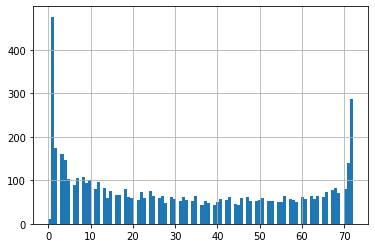

In [ ]:
train_val_data['tenure'].hist(bins = 100)

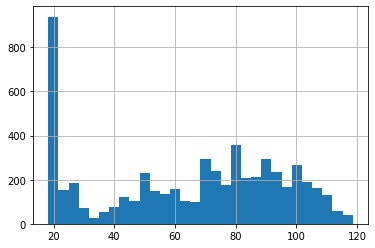

In [ ]:
train_val_data['MonthlyCharges'].hist(bins = 30)

In [ ]:
train_val_data.corr()

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.008823,0.217649
tenure,0.008823,1.000000,0.253803
MonthlyCharges,0.217649,0.253803,1.000000


## Data cleaning 

## Feature engineering 



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#from utils.tenure_lab import tenure_lab

class FeaturePipe: 
  def __init__(self):
    self.scaler = StandardScaler()

  def feature_engineering(self, telcom, test_set =False):
    """
    Takes in dataframe from file and performs feature engineering.
    Outputs dataframe with features, scaled dataframe, columns for modelling and target column.
    """

    #Replacing spaces with null values in total charges column
    telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan)

    #Dropping null values from total charges column which contain .15% missing data 
    telcom = telcom[telcom["TotalCharges"].notnull()]
    telcom = telcom.reset_index()[telcom.columns]

    #convert to float type
    telcom["TotalCharges"] = telcom["TotalCharges"].astype(float)

    #replace 'No internet service' to No for the following columns
    replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies']

    for i in replace_cols:
      telcom[i]  = telcom[i].replace({'No internet service' : 'No'})

    #replace values
    telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})

    #telcom["tenure_group"] = telcom.apply(lambda telcom:tenure_lab(telcom), axis = 1)

    #Separating churn and non churn customers
    churn     = telcom[telcom["Churn"] == "Yes"]
    not_churn = telcom[telcom["Churn"] == "No"]

    #Separating catagorical and numerical columns
    Id_col     = ['customerID']
    target_col = ["Churn"]
    cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
    cat_cols   = [x for x in cat_cols if x not in target_col]
    num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]

    #customer id col
    Id_col     = ['customerID']
    #Target columns
    target_col = ["Churn"]
    #categorical columns
    cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
    cat_cols   = [x for x in cat_cols if x not in target_col]
    #numerical columns
    num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
    #Binary columns with 2 values
    bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
    #Columns more than 2 values
    multi_cols = [i for i in cat_cols if i not in bin_cols]

    #Label encoding Binary columns
    le = LabelEncoder()
    for i in bin_cols :
      telcom[i] = le.fit_transform(telcom[i])

    #Duplicating columns for multi value columns
    telcom = pd.get_dummies(data = telcom,columns = multi_cols )

    #Scaling Numerical columns
    if test_set ==False: 
      scaled = self.scaler.fit_transform(telcom[num_cols])
    else: 
      scaled = self.scaler.transform(telcom[num_cols])

    telcom[num_cols] = pd.DataFrame(scaled,columns=num_cols)

    return [telcom, Id_col, target_col, cat_cols, multi_cols, num_cols]

In [ ]:
featurepipe = FeaturePipe()

train_val_feature_engineered, id_col, target_col,cat_cols, multi_cols, num_cols =featurepipe.feature_engineering(train_val_data)


In [ ]:
train_val_feature_engineered.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,4223-BKEOR,0,0,0,1,-0.468357,1,1,0,1,...,1,0,0,0,1,0,0,0,0,1
1,6035-RIIOM,0,0,0,0,0.883777,1,0,1,0,...,0,1,0,0,0,1,1,0,0,0
2,3797-VTIDR,1,0,1,0,-1.287832,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,2568-BRGYX,1,0,0,0,-1.164911,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0
4,4291-SHSBH,1,0,0,0,-1.041990,1,0,0,0,...,0,1,0,1,0,0,0,0,1,0


## Split into train and validation set for training 

In [ ]:
val_test_size = 0.2

train , val = train_test_split(train_val_feature_engineered,                       
                                 test_size = holdout_test_size, 
                                 shuffle= True, 
                                 random_state =seed)


In [ ]:
X_cols = train_val_feature_engineered.columns.values.tolist() 
X_cols.remove('Churn')
X_cols.remove('customerID')

X_train = train[X_cols]
y_train = train[target_col[0]]
X_val = val[X_cols]
y_val = val[target_col[0]]

## Train and evaluate model

In [ ]:

from xgboost import XGBClassifier

xgc = XGBClassifier(objective="binary:logistic")

model = xgc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric=['error', 'logloss'], verbose=10)


[0]	validation_0-error:0.209602	validation_0-logloss:0.651789	validation_1-error:0.218667	validation_1-logloss:0.65591
[10]	validation_0-error:0.200711	validation_0-logloss:0.472714	validation_1-error:0.218667	validation_1-logloss:0.501612
[20]	validation_0-error:0.197377	validation_0-logloss:0.424871	validation_1-error:0.222222	validation_1-logloss:0.465407
[30]	validation_0-error:0.18982	validation_0-logloss:0.405829	validation_1-error:0.219556	validation_1-logloss:0.455095
[40]	validation_0-error:0.186264	validation_0-logloss:0.395687	validation_1-error:0.212444	validation_1-logloss:0.450929
[50]	validation_0-error:0.184041	validation_0-logloss:0.389465	validation_1-error:0.214222	validation_1-logloss:0.451267
[60]	validation_0-error:0.184263	validation_0-logloss:0.384863	validation_1-error:0.216889	validation_1-logloss:0.452727
[70]	validation_0-error:0.181818	validation_0-logloss:0.381242	validation_1-error:0.214222	validation_1-logloss:0.454149
[80]	validation_0-error:0.181596	va

### *Task: How can we make this better?*

### LightGBM model

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


In [ ]:
## Use only if LightGBM

not_num_cols = [i for i in train_val_feature_engineered.columns if i not in num_cols + target_col + id_col]
not_num_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'PaperlessBilling',
 'MultipleLines_No',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_DSL',
 'InternetService_Fiber optic',
 'InternetService_No',
 'Contract_Month-to-month',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Bank transfer (automatic)',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [ ]:
X_train_lgb = X_train
X_val_lgb = X_val 
X_train_lgb[not_num_cols] = X_train_lgb[not_num_cols].astype('category')
X_val_lgb[not_num_cols] = X_val_lgb[not_num_cols].astype('category')
y_train  =y_train.astype('category')
y_val  =y_val.astype('category')

lgb_train_set = lgb.Dataset(X_train_lgb,label= y_train) #, categorical_feature= cat_cols)
lgb_val_set = lgb.Dataset(X_val_lgb,label= y_val) #, categorical_feature= cat_cols)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
X_val_lgb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1125 entries, 3494 to 291
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   gender                                   1125 non-null   category
 1   SeniorCitizen                            1125 non-null   category
 2   Partner                                  1125 non-null   category
 3   Dependents                               1125 non-null   category
 4   tenure                                   1125 non-null   float64 
 5   PhoneService                             1125 non-null   category
 6   OnlineSecurity                           1125 non-null   category
 7   OnlineBackup                             1125 non-null   category
 8   DeviceProtection                         1125 non-null   category
 9   TechSupport                              1125 non-null   category
 10  StreamingTV                       

In [ ]:
# Set hyperparameters 

params = {
        "objective" : "binary",
        #"metric" :"logloss",
        #"force_row_wise" : False,
        "learning_rate" : 0.075,
        "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
         "nthread" : 4,
        #"eval_metric": ["logloss"],
    'verbosity': 2,
    'num_iterations' : 3000, 
    }
  


In [ ]:
#train model 
lgbm_model = lgb.train(params, train_set = lgb_train_set, 
                       num_boost_round = 2000,
                       early_stopping_rounds = 200, 
                       valid_sets =  lgb_val_set, 
                       verbose_eval = 1)

Found `num_iterations` in params. Will use it instead of argument


[1]	valid_0's binary_logloss: 0.588196
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.569212
[3]	valid_0's binary_logloss: 0.552722
[4]	valid_0's binary_logloss: 0.53955
[5]	valid_0's binary_logloss: 0.527842
[6]	valid_0's binary_logloss: 0.518684
[7]	valid_0's binary_logloss: 0.50956
[8]	valid_0's binary_logloss: 0.502294
[9]	valid_0's binary_logloss: 0.496655
[10]	valid_0's binary_logloss: 0.490681
[11]	valid_0's binary_logloss: 0.485335
[12]	valid_0's binary_logloss: 0.480532
[13]	valid_0's binary_logloss: 0.477098
[14]	valid_0's binary_logloss: 0.474196
[15]	valid_0's binary_logloss: 0.470949
[16]	valid_0's binary_logloss: 0.468026
[17]	valid_0's binary_logloss: 0.466748
[18]	valid_0's binary_logloss: 0.465257
[19]	valid_0's binary_logloss: 0.464078
[20]	valid_0's binary_logloss: 0.462177
[21]	valid_0's binary_logloss: 0.461251
[22]	valid_0's binary_logloss: 0.460663
[23]	valid_0's binary_logloss: 0.459347
[24]	valid_0's binary_loglos

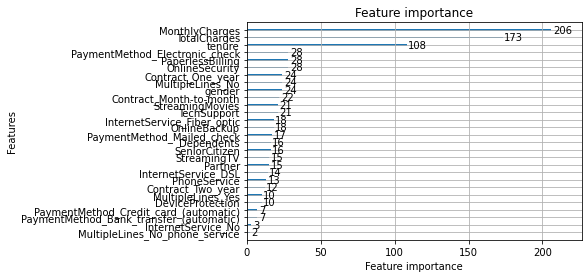

In [ ]:
# Plot feature importance 
lgb.plot_importance(lgbm_model,max_num_features = 100)


## Evaluate model on the test set

In [ ]:
test_feature_engineered, id_col, target_col,cat_cols, multi_cols, num_cols =featurepipe.feature_engineering(holdout_test_data, test_set = True)


In [ ]:
X_test = test_feature_engineered[X_cols]
y_test = test_feature_engineered[target_col[0]]

### Evaluate XGBoost

In [ ]:
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix

x_test = test_feature_engineered
predictions = model.predict(X_test)
acc = accuracy_score(y_test.values.ravel(), predictions)
loss = log_loss(y_test.values.ravel(), predictions)

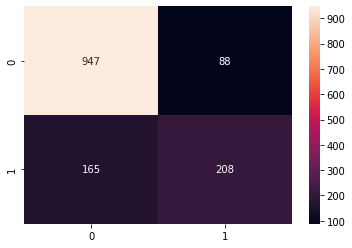

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, predictions)
conf_mat_plot = sns.heatmap(conf_mat, annot=True, fmt='g')

### Evaluate LightGBM

In [ ]:
X_test_lgb = X_test
X_test_lgb[not_num_cols] = X_test_lgb[not_num_cols].astype('category')
y_test_lgb =y_test
y_test_lgb = y_test.astype('category')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
threshold = 0.5 

predictions_lgb = lgbm_model.predict(X_test_lgb)

predictions_lgb_binary = np.where(predictions_lgb >threshold, 1,0).astype(int)
predictions_lgb_binary

array([1, 0, 0, ..., 0, 0, 1])

In [ ]:
acc_lgb = accuracy_score(y_test_lgb, predictions_lgb_binary)

loss_lgb = log_loss(y_test_lgb, predictions_lgb_binary)

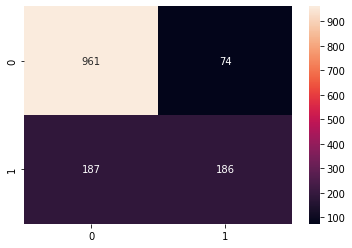

In [ ]:
conf_mat_lgb = confusion_matrix(y_test.values.ravel(), predictions_lgb_binary)
conf_mat_plot_lgb = sns.heatmap(conf_mat_lgb, annot=True, fmt='g')

## Explain model with SHAP

In [ ]:
! pip install shap 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.2 MB/s 


## Explain XGBoost

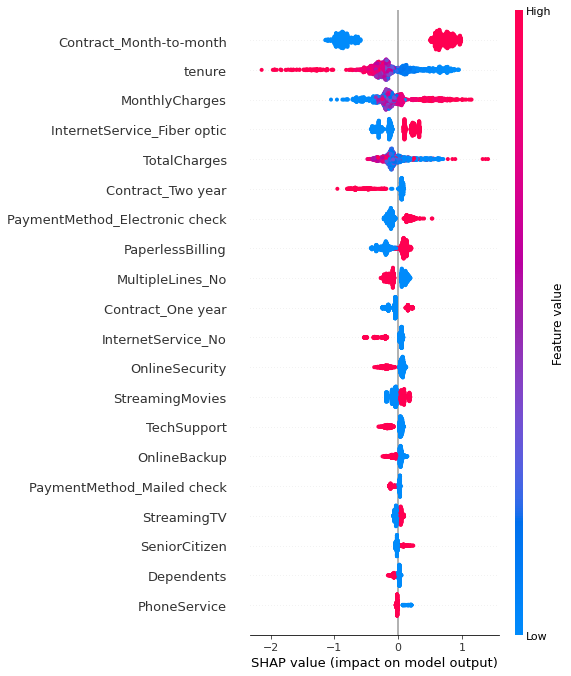

In [ ]:
#Shap summary plot 
import shap

explainer = shap.TreeExplainer(model,)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val)